## Robust Facial Landmark Detection via a Fully-Convolutional Local-Global Context Network

![landmark-detection](https://www.mmk.ei.tum.de/fileadmin/_processed_/csm_cvpr2018_435e9d89e5.png)
* Facial landmarks are used to localize and represent salient regions of the face, such as: Eyes, Eyebrows, Nose, Mouth, Jawline
* Challenges: different shapes, poses, lighting conditions, occlusions, etc.
* Uses of landmark detection: face alignment, head pose estimation, face swapping, blink detection and much more.
* Following is an iPython Notebook implementation of paper:
  * Robust Facial Landmark Detection via a Fully-Convolutional Local-Global Context Network, Proceedings of the International Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, 2018 - Daniel Merget, Matthias Rock, Gerhard Rigoll
  * Link: https://www.mmk.ei.tum.de/fileadmin/w00bqn/www/Verschiedenes/cvpr2018.pdf
* Code is written in brainscript and also Python using Microsoft CNTK and for post-processing Matlab is used.
* Code and other details can be found [here](https://www.mmk.ei.tum.de/cvpr2018/).

### Important notes from the paper
* Fully convolutional NN are good at modeling local features, but it results to constrained receptive field (local context).
* To overcome this there are many ways: cascades/pooling etc. This paper proposes a new approach to use channel-wise/kernel convolution and dilated convolution (global context) to achieve the same with better accuracy than several SOTA methods. It introduces global context into a fully-convolutional neural network directly.
* Major Contributions:
  * Uses Kernel Convolution directly within the network
  * Uses Dilated Convolutions to increase receptive field
  * Doesn’t depend on prior face detections
  * Input image is directly mapped to heatmap based tensor allowing the network to be accurate and robust

### Our Work-Plan
* Our plan is to port their code to python so that it can be run on Google Colab for our experimentation and then later make it production ready
* Steps to be followed:
  1. Port CNTK neural network code to Keras
  2. Port Matlab post-processing code to Python
  3. Train the network using 300-W dataset
  4. Make it work for multiple-faces (images from wild)
  
  

### Get CNTK working on Colab

* To understand the code we will have to get CNTK running on Colab
* Following changes are done to install necessary packages
* CNTK code will only run on GPU as "DIlated convolution" function (CNTK implementation) can only work for GPU

In [223]:
import os

!sed -i 's/artful/xenial/g' /etc/apt/sources.list
!apt-get update

!wget -q -O /tmp/libpng12.deb http://mirrors.kernel.org/ubuntu/pool/main/libp/libpng/libpng12-0_1.2.54-1ubuntu1_amd64.deb \
  && dpkg -i /tmp/libpng12.deb \
  && rm /tmp/libpng12.deb

!apt-get install openmpi-common=1.10.2-8ubuntu1 libopenmpi1.10 openmpi-bin=1.10.2-8ubuntu1 libtiff5 libjasper-dev

!pip install cntk-gpu pydot_ng cvxopt

os.environ["LD_LIBRARY_PATH"] += ":/usr/lib/"

Hit:1 http://archive.ubuntu.com/ubuntu xenial InRelease
Get:2 http://security.ubuntu.com/ubuntu xenial-security InRelease [107 kB]
Get:3 http://archive.ubuntu.com/ubuntu xenial-updates InRelease [109 kB]
Get:4 http://archive.ubuntu.com/ubuntu xenial-backports InRelease [107 kB]
Get:5 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 Packages [1,087 kB]
Fetched 1,410 kB in 3s (436 kB/s)
Reading package lists... Done
(Reading database ... 18839 files and directories currently installed.)
Preparing to unpack /tmp/libpng12.deb ...
Unpacking libpng12-0:amd64 (1.2.54-1ubuntu1) over (1.2.54-1ubuntu1) ...
Setting up libpng12-0:amd64 (1.2.54-1ubuntu1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenmpi1.10 is already the newest version (1.10.2-8ubuntu1).
openmpi-bin is already the newest version (1.10.2-8ubuntu1).
openmpi-common is already the newest version (1.10.2-8ubuntu

### Load input images
* Code requires input images to be downloaded and path be specified in **img.txt** file

In [224]:
import subprocess

def download_file(input_list):
    with open("img.txt", 'w') as f_input:
      fcnt = 1
      for url in input_list:
        filename = "input_img%d.jpg" % (fcnt)
        print("Downloading %s..." % filename, end='')
        output = subprocess.Popen("wget %s -O %s" % (url, filename), stdout=subprocess.PIPE, shell=True)
        f_input.write("./%s\t0\n" % filename)
        print("Done")
        fcnt += 1
    return

input_list = [
    "https://drive.google.com/uc\?export\=download\&id\=1nui-mBidqH1e8lNpg_jasRhQJDX_T1MF",
    #"https://drive.google.com/uc\?export\=download\&id\=1mC_fPbe7YT3x6QtCw9CTGHMh01mEjz3C",
    #"https://res.cloudinary.com/demo/image/upload/w_0.5/young_couple.jpg",
    #"http://dericbownds.net/uploaded_images/m_sexy.jpg",
    #"https://www.nbcsports.com/sites/nbcsports.com/files/2018/04/27/nbc_nhl_ellisskatetoface_180427_1920x1080.jpg",
    #"http://cvl-demos.cs.nott.ac.uk/vrn/queue/59b419de805ba.jpg",
]

download_file(input_list)

!echo "\nimg.txt:"
!cat img.txt


img.txt:
./input_img1.jpg	0


### python/helpers/include.py
* Following is a copy of file python/helpers/include.py
* Only modification done here is change in path/directory location

In [0]:
from __future__ import print_function
import os
import re
import sys
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import multiprocessing
import pydot_ng
import cntk as C
import numpy as np
from cntk.ops import *
from cntk.layers.typing import *
from cntk.losses import squared_error
import time
import scipy.io as sio
from pathlib import Path
from _cntk_py import set_computation_network_trace_level, force_deterministic_algorithms
import cntk.io.transforms as xforms
from cntk.ops.functions import load_model
from cntk.layers import *
from cntk.device import try_set_default_device, gpu, cpu
from cntk.io import MinibatchSource, ImageDeserializer, CTFDeserializer, StreamDef, StreamDefs
from cntk.learners import momentum_sgd, learning_parameter_schedule_per_sample, UnitType, momentum_schedule
from cntk.logging import ProgressPrinter
import cntk.logging.graph as logging
from IPython.core.debugger import Tracer
from cntk.initializer import *

try_set_default_device(gpu(0))
set_computation_network_trace_level(0)

#############################
#   Adapt these parameters  #
#############################
numLabels 			= 68
ImageW 				= 96
ImageH 				= 96
dropoutRate			= 0.1
Grayscale 			= True
OutputDir			= 'output'
ModelsPath 			= 'models/model.%d'
LogFileDir			= 'logs'

##############################
#  File names & Directories  #
##############################
Dir_PathAbs 			= './'
OutputDir_PathAbs 		= Dir_PathAbs + OutputDir
Models_PathAbs			= OutputDir_PathAbs + '/' + ModelsPath
LogFileDir_PathAbs		= OutputDir_PathAbs + '/' + LogFileDir

if Grayscale:
	ImageC = 1
else:
	ImageC = 3

#############################
#      Reader functions     #
#############################

# Reader for images
def create_feature_deserializer(path):
	transforms 		= [xforms.scale(width = ImageW, height = ImageH, channels = ImageC, interpolations = "linear")]
	deserializer 	= ImageDeserializer(
		path,
		StreamDefs(
			features = StreamDef(field = 'image', transforms = transforms),
			ignored	 = StreamDef(field = 'label', shape = 1)
		)
	)
	deserializer['grayscale'] = Grayscale
	
	return deserializer

# Reader for mask
def create_mask_deserializer(path):
	return CTFDeserializer(
		path,
		StreamDefs(
			mask = StreamDef(field = 'mask', shape = numLabels)
		)
	)

# Reader for labels/heatmaps
def create_label_deserializer_list(path):
	transforms 	= [xforms.scale(width = ImageW, height = ImageH, channels = 1, interpolations = "linear")]
	list	 	= []
	
	for x in range(1, numLabels + 1):
		deserializer = ImageDeserializer(
			path % x,
			eval("StreamDefs(label%d = StreamDef(field = 'image', transforms = transforms), ignored%d = StreamDef(field = 'label', shape = 1))" % (x, x))
		)
		deserializer['grayscale'] = True
		list.append(deserializer)
	
	return list

### Download pre-trained model & additional data
* Original authors have provided pre-trained model and additional data which is used for post-processing
* We have put it on Google Drive and are downloading it in Colab

In [226]:
!mkdir -p ./output/logs
!wget https://drive.google.com/uc\?export\=download\&id\=1kCB6wnBHp7NJXkk1bmov2zJ_PINGCpU8 -O ./output/logs/train_val.log
!mkdir -p ./output/models
!wget https://drive.google.com/uc\?export\=download\&id\=1lw9W2NzYrrnXCAPOteIDzkUg6hKqS6-t -O ./output/models/model.21
!wget https://drive.google.com/uc\?export\=download\&id\=1cOKB1NoRRfFHqMKHUH1kmMPcqCy78gt8 -O paper_params.mat
!mkdir -p ./train
!wget https://drive.google.com/uc\?export\=download\&id\=1s_4Vy47gutEPEx52QFYFnfVntMARRSZh -O ./train/300W_train.mat
!wget https://drive.google.com/uc\?export\=download\&id\=1HZTw1fXkNaBmUJVBxalPixngFEca8yhl -O ./train/theta.mat
!mkdir -p ./test
!wget https://drive.google.com/uc\?export\=download\&id\=1ubDFF79FXyzxQ-_wm47qS8TvN_EtETM8 -O ./test/theta.mat

--2018-09-05 17:36:40--  https://drive.google.com/uc?export=download&id=1kCB6wnBHp7NJXkk1bmov2zJ_PINGCpU8
Resolving drive.google.com (drive.google.com)... 74.125.204.113, 74.125.204.100, 74.125.204.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.204.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g0kd5q2e82d609d7kcjbhs0k7f5lcqj8/1536163200000/16850052619694981580/*/1kCB6wnBHp7NJXkk1bmov2zJ_PINGCpU8?e=download [following]
--2018-09-05 17:36:41--  https://doc-0c-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g0kd5q2e82d609d7kcjbhs0k7f5lcqj8/1536163200000/16850052619694981580/*/1kCB6wnBHp7NJXkk1bmov2zJ_PINGCpU8?e=download
Resolving doc-0c-1o-docs.googleusercontent.com (doc-0c-1o-docs.googleusercontent.com)... 64.233.188.132, 2404:6800:4008:c06::84
Connecting to doc-0c-1o-docs.googleusercontent.com (doc-0c

### python/predict.py
* Copy of python/predict.py
* Following code will load the model and run with input images (as mentioned in img.txt)

In [227]:
#############################
#   Adapt these parameters  #
#############################
minibatchSize = 16

#############################
#  File names & directories  #
#############################
TestDir_PathAbs		= Dir_PathAbs
FeatureTest_PathAbs	= TestDir_PathAbs 	+ '/img.txt'
OutputFile_PathAbs	= OutputDir_PathAbs + '/prediction.mat'

##############################
# Determine number of images #
##############################
number_images = 0

with open(FeatureTest_PathAbs) as file:
	for line in file:
		if line.strip():
			number_images += 1		

#####################################
# Extract best model from log files #
#####################################
log_content = ""

# Read all log files
for file in os.listdir(LogFileDir_PathAbs):
	if file.endswith(".log"):
		# Read content of the logfile
		f = open(os.path.join(LogFileDir_PathAbs, file),'r')
		log_content	= log_content + f.read()
		f.close()

#print(log_content)
# Extract the validation errors of all epochs
result = re.findall('Finished Evaluation \[(\d+)\]: Minibatch\[\d+\-\d+\]: metric = (\d+.\d+)', log_content, flags=re.DOTALL)

# Find out the best epoch
best_model = min(result, key=lambda x: float(x[1]))
best_model = int(best_model[0])
			
#############################
#        Load model         #
#############################

model		= load_model(Models_PathAbs % best_model)
features	= model.find_by_name('features')

#############################
#      Read input data      #
#############################

reader = MinibatchSource(create_feature_deserializer(FeatureTest_PathAbs), trace_level = 1, randomize = False)

# Define mapping from reader stream to network input
input_map 				= {}
input_map[features] 	= reader.streams.features

#############################
#        Prediction         #
#############################
sample_count 	= 0
output 			= np.zeros((number_images, numLabels, ImageH, ImageW), dtype = np.float32)

print("##################################################")
print("##############   Start Prediction   ##############")
print("##################################################\n")
print("Using model of epoch %d\n" % best_model)
print("Prediction:   0 %% (% 5.1f samples/s)"% 0, end = '', flush = True)

while sample_count < number_images:
	t_start_mb		= time.time()
	currentMBsize 	= min(minibatchSize, number_images - sample_count)
	data 			= reader.next_minibatch(currentMBsize, input_map = input_map)
	output_mb 		= model.eval(data)
	
	output[sample_count:sample_count+currentMBsize,] = np.squeeze(output_mb)
	sample_count += currentMBsize

	sys.stdout.write('\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b')
	print("% 3d %% (% 5.1f samples/s)" % (math.floor(100*sample_count/number_images), currentMBsize/(time.time()-t_start_mb)), end = '', flush = True)

sys.stdout.write('\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b')
print("                  ")

print("\nSaving file...", end = '', flush = True)
sio.savemat(OutputFile_PathAbs, {'pred':np.transpose(output)})
print("Finished!\n")

##################################################
##############   Start Prediction   ##############
##################################################

Using model of epoch 21

Prediction:   0 % (  0.0 samples/s) 100 % (  1.4 samples/s)                  

Saving file...Finished!



### Load output from network
* Network will output predicted landmarks in prediction.mat

In [228]:
%matplotlib inline
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt

matfile = "./output/prediction.mat"
matdata = spio.loadmat(matfile)

pred = matdata['pred']
print("Img Size: %dx%d, Landmarks: %d, Num of Images: %d" % (pred.shape))
imgszx, imgszy, lmn, imgn = pred.shape

Img Size: 96x96, Landmarks: 68, Num of Images: 1


### Plot landmarks on image
* Following code will plot landmark points (x,y) on input image and display it

In [0]:
def plot_landmarks(imgnum, lmn, x, y):
  img_file = "./input_img%d.jpg" % imgnum
  print("%s:" % img_file)
  plt.imshow(plt.imread(img_file))
  for i_lmn in range(lmn):
    plt.scatter(x[i_lmn], y[i_lmn], c='r', s=10)
  plt.show()

### Global Heatmap Maxima
* Following will pick maximum heatmap point from each landmark and plot on input image
* It will also display prediction heatmap output for each landmark

./input_img1.jpg:


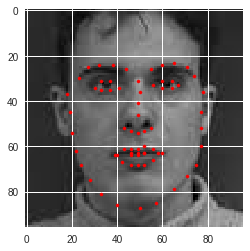

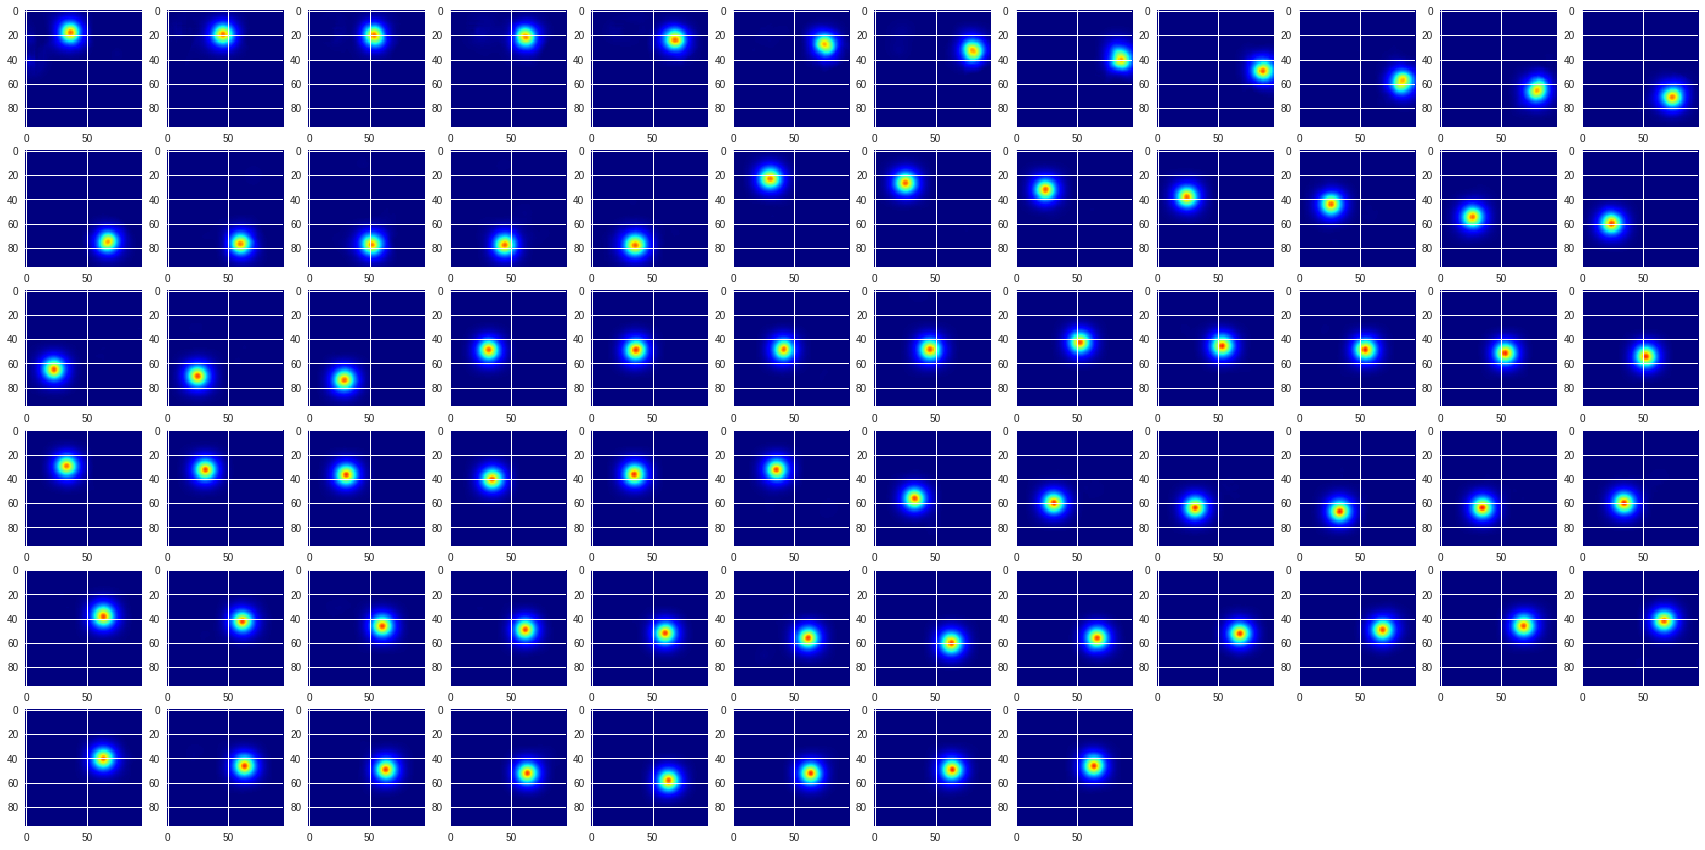

In [230]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cv2

pred[pred < 0] = 0

# For heatmaps
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.jet

x_max = np.zeros((lmn, imgn))
y_max = np.zeros((lmn, imgn))

w = 96
h = 96
columns = 12
rows = 6
for i_imgn in range(imgn):
  for i_lmn in range(lmn):
    i_pred = pred[:, :, i_lmn, i_imgn]
    i_pred = cv2.resize(i_pred, dsize=(img.shape[0], img.shape[1]),
                        interpolation=cv2.INTER_CUBIC)
    # Threshold
    # lmn_cords = np.argwhere(i_pred > 0.1)
    # plt.scatter(lmn_cords[:,0], lmn_cords[:,1], c='r', s=10)
    px, py = np.unravel_index(i_pred[:].argmax(), i_pred.shape)
    x_max[i_lmn, i_imgn] = px
    y_max[i_lmn, i_imgn] = py
  plot_landmarks(i_imgn+1, lmn, x_max[:, i_imgn], y_max[:, i_imgn])
  
  # Plot heatmaps
  fig=plt.figure(figsize=(30, 15))
  for i_lmn in range(lmn):
    i_pred = pred[:, :, i_lmn, i_imgn]
    i_pred = cv2.resize(i_pred, dsize=(img.shape[1], img.shape[0]))
    fig.add_subplot(rows, columns, i_lmn+1)
    rgba = cmap(norm(i_pred))
    plt.imshow(rgba)
  plt.show()

In [231]:
imgszx = 96
imgszy = 96
lmn = 68

outline = list(range(17))
outline.extend([60, 64])

no_outline = list(range(17, 60))
no_outline.extend(range(61, 64))
no_outline.extend(range(65, 68))

# 2a) Parameters for model fitting
compat = True; # compat = true overrides the parameters below!!!
# ^ use compat = true if you want to reproduce the numbers exactly
# as reported in the paper, otherwise use compat = false

thresh = 0.1 # lower => consider more landmarks (depending on network certainty) for Kabsch alignment
# ^ should be between 0 and 1.
# ^ in the paper, we did not use this threshold, but feel free to experiment

nEVs = 12 # number of eigenvectors to consider for fitting
# ^ in the paper, we used nEVs = 12, but feel free to experiment

window_sizes = [20, 7] # local fit window sizes, empty vector to disable local fitting
# ^ in the paper, we used window_sizes = [20 7], but feel free to experiment

model_constraints = True # constrain the fitting to "plausible" shapes according to the training set
# ^ in the paper, we used model_constraints = true, but feel free to experiment

image_boundary_constraints = False # constrain the fitting to regions within the image boundary
# ^ in the paper, we used image_boundary_constraints = false, but feel free to experiment

noisedeg = 0 # randomly rotate the training faces by up to +/- noisedeg degrees (uniform distribution)
# ^ used to increase robustness towards alignment errors (at the cost of more overfitting)
# ^ in the paper, we did not use this (noisedeg = 0), but feel free to experiment

if compat:
  matdata = spio.loadmat('./paper_params.mat')
  image_boundary_constraints = matdata['image_boundary_constraints'][0][0]
  model_constraints = matdata['model_constraints'][0][0]
  nEVs = matdata['nEVs'][0][0]
  noisedeg = matdata['noisedeg'][0][0]
  thresh = matdata['thresh'][0][0]
  window_sizes = matdata['window_sizes'][0]
  
print("image_boundary_constraints => %s" % image_boundary_constraints)
print("model_constraints => %s" % model_constraints)
print("nEVs => %s" % nEVs)
print("noisedeg => %s" % noisedeg)
print("thresh => %s" % thresh)
print("window_sizes => %s" % window_sizes)

image_boundary_constraints => 0
model_constraints => 1
nEVs => 12
noisedeg => 0
thresh => -1
window_sizes => [20  7]


In [0]:
from skimage import feature

#
# Helper Functions:
# Reference for some of the function:
#  https://docs.scipy.org/doc/numpy-1.14.0/user/numpy-for-matlab-users.html
#

def ml_reshape(inp, dims):
  return np.reshape(inp, dims, order='F').copy()

def minmax(x, mini, maxi):
  # MINMAX truncate x to [mini...maxi]
  return np.minimum(np.maximum(x, mini), maxi)

def repmat(mat, dims):
  return np.tile(mat, dims)

def permute(mat, dims):
  return np.transpose(mat, dims)

def tocol(inp):
  return inp.reshape((np.prod(inp.shape), 1), order='F')

def imregionalmax(image, ksize=3):
  filterkernel = np.ones((ksize, ksize)) # 8-connectivity
  reg_max_loc = feature.peak_local_max(image, footprint=filterkernel,
                                       indices=False, exclude_border=0)
  return reg_max_loc.astype(np.uint8)

def ind2sub( dim, shap, lst ):
    # Ref: https://mail.python.org/pipermail/scipy-user/2010-April/024996.html
    '''
    I1, I2, I3, ..., Idim = ind2sub(dim, shap, lst)
    Input:
        dim - number of dimensions
        shap - shape of the array
        lst - list of indicies
    Output:
        list of subscripts
    r = array([[0,1,0,0],[0,0,1,1],[1,1,1,0],[1,0,0,1]])
    l = find(r==1)
    [cols,rows] = ind2sub(2, r.shape, l)
    * The element in coulmn cols[i], and row rows[i] is 1.
    '''
    if len(shap) <= dim:
        shap = shap + tuple(np.zeros((dim - len(shap),)))
    else:
        shap = shap[0:dim-1] + (np.prod(shap[(dim-1):]),)

    n = len(shap)
    k = np.array([1] + np.cumprod(shap[0:(n-1)]).tolist())

    argout = [np.zeros((len(lst),))]*n

    for i in range(n-1,-1,-1):
        vi = (lst)%k[i]
        vj = (lst-vi)/k[i]
        argout[i] = vj
        lst = vi
    return argout
  
def sub2ind(p, x, y, imgszx, imgszy, lmn):
  # Get value from p for location x,y for all landmarks
  dim0 = minmax(round(x), 0, imgszx-1)
  dim1 = minmax(round(y), 0, imgszy-1)
  dim2 = np.arange(lmn).reshape((1, lmn))
  return p[dim0, dim1, dim2]
  
def cell2mat(data, dxy):
  out = []
  for i in data:
    z = int(i[0])
    temp = []
    for j in range(z-dxy, z+dxy+1):
      temp.append(j)
    out.append(temp)
  return np.asarray(out)

def sum1( data, stop = np.inf):
  # DIFF1 normalizes the input "in" so that it sums to 1 over the
  #   first "stop" dimensions
  # 0/0 is treated as 0
  # default: all dimensions
  m = data;
  for i in range(1,int(np.minimum(stop, data.ndim))):
      m = np.sum(m);
  out = data/m
  out[np.isnan(out)]=0;
  return out

def max1( data, stop=np.inf):
  # DIFF1 normalizes the input "in" to [min/max...1] over the
  #   first "stop" dimensions
  # default: all dimensions
  m = data;
  for i in range(1,int(np.minimum(stop, data.ndim))):
    m = np.max(m);
  out = data/m
  return out

def diff1( data, stop=np.inf):
  # DIFF1 normalizes the input "in" to [0...1] over the
  #    first "stop" dimensions
  # default: all dimensions
  data = np.asarray(data);
  m = data
  for i in range(1,int(np.minimum(stop, data.ndim))):
    m = np.min(m);
  m = data-m;
  out = max1(m,stop);
  return out

def rotmat(theta):
  # ROTMAT returns a rotation matrix for 2d vectors
  # matlab plotting compatibility
  theta = -theta
  c = np.cos(np.deg2rad(theta)) # cosd
  s = np.sin(np.deg2rad(theta)) # sind
  mat = np.array([[c, -s], [s, c]])
  return mat

def allign_training_set(train_labels, noisedeg=0, imsz=96, compat=False):
  if compat:
    matdata = spio.loadmat('./train/theta.mat');
    theta2 = matdata['theta2'];
  else:
    matdata = spio.loadmat('train/300W_train.mat');
    mean_face = matdata['mean_face']
  
  new_labels = np.zeros(train_labels.shape)
  for k in range(0, train_labels.shape[0]):
    t = train_labels[k,:];
    t=t[:];
    # Find rotation relative to mean face using Kabsch algorithm ...
    if compat:
      theta = theta2[0][k];
    else:
      theta = kabsch([t[0:t.size:2],t[1:t.size:2]], mean_face) + math.ceil(
          np.random.rand(1+2*noisedeg))- noisedeg- 1
    #... and apply it
    R = np.kron(np.eye(int(t.size/2)), rotmat(-theta));
    t = np.matmul(R,(t-(imsz+1)/2))+(imsz+1)/2 # rotate around image center
    new_labels[k,0:new_labels.size:2]=t[0:t.size:2];
    new_labels[k,1:new_labels.size:2]=t[1:t.size:2];
  return new_labels;

def diff_matrix(s):
  if s < 2:
    print("size must be greater than 2")
    return
  
  """
  For s=3, Output:
  d =

   1  -1   0
   1   0  -1
   0   1  -1
  """

  d = np.array([[1, -1]])
  for i in range(2, s):
    nd = np.concatenate([np.ones((i,1)), -np.eye(i)],1)
    pad = np.zeros([d.shape[0], 1])
    d = np.concatenate([nd, np.concatenate([pad, d], 1)])
  
  return d  

def kabsch(A, B):
  # Simple implementation of the Kabsch algorithm without reflection detection
  # Finds the rotation angle and translation vector between two 2D point sets
  # Input dimension: N x 2
  
  # assert(all(size(A) == size(B)) and size(A,2) == 2)
  meanA = np.mean(A,axis=1)
  meanB = np.mean(B,axis=0)
  
  # bsxfun(@minus,A,meanA)
  bsxA = np.array([(A[0]-meanA[0]), (A[1]-meanA[1])])
  bsxB = np.array([(B[:,0]-meanB[0]), (B[:,1]-meanB[1])])
  
  # svd
  U, s, V = np.linalg.svd(np.matmul(bsxA, np.transpose(bsxB)))

  # rotation matrix (2x2)
  R = np.matmul(V, np.transpose(U))
  
  # rotation angle (1x1)
  theta = np.rad2deg(np.math.asin(R[1,0]))

  # translation vector (2x1)
  t = np.matmul(-R, np.transpose(meanA)) + np.transpose(meanB)

  return theta

In [0]:
import collections

def new_pca_model(train_labels, noisedeg=0, imsz=96, compat=False):
  
  #
  # * NEW_PCA_MODEL returns a ShapeModel struct
  # * ShapeModel.avg is the mean face
  # * ShapeModel.C is the landmark coordinate difference generating matrix
  # * ShapeModel.diffs contains the percentage of negative results for each
  #   of the coordinate differences
  # * ShapeModel.EVs contains all PCA principal componets
  # * ShapeModel.S contains the corresponding eigenvalues
  # * ShapeModel.n contains the suggested number of principal components to be
  #   retained
  #

  ShapeModel = collections.namedtuple('ShapeModel', ['avg','C','diffs', 'EVs',
                                                     'S', 'n', 'constrained'])
  # cleanup, remove partially labelled data
  train_labels = train_labels[np.any(np.any(train_labels >= -1000, 1), 1), :, :]
  print("Post cleanup shape ", train_labels.shape)

  # from x y to face vectors
  # rows of train_labels: [x1 y1 x2 y2 ... xN yN]
  train_labels = train_labels.reshape(train_labels.shape[0],
                                      train_labels.shape[2] *
                                      train_labels.shape[1])
  print("Face vector shape ", train_labels.shape)

  train_labels = allign_training_set(train_labels,noisedeg,imsz,compat);
  # calculate shape average
  ShapeModel.avg = np.mean(train_labels,0).reshape(1, train_labels.shape[1])
  print("SM-Avg shape ", ShapeModel.avg.shape)
  
  lmn = int(train_labels.shape[1]/2)
  d = diff_matrix(lmn)

  r1 = np.concatenate([d, np.zeros(d.shape)], 1)
  r2 = np.concatenate([np.zeros(d.shape), d], 1)
  D = np.concatenate([r1, r2])
  print("D Shape ", D.shape)
  
  e = np.eye(2*lmn)
  perm = np.concatenate([np.arange(0, 2*lmn, 2), np.arange(1, 2*lmn, 2)])
  E = e[perm, :]
  print("E Shape ", E.shape)
  
  C = np.matmul(D, E)
  C = np.concatenate([C, -C])
  ShapeModel.C = C
  print("SM-C shape ", C.shape)
  
  #
  # C*face_vector results in a vector with all the landmark coordinate
  # differences for each axis
  # [x1-x2; x1-x3; x1-x4;...;yN-1 - yN ...
  # x2-x1; x3-x1; x4-x1;...;yN- yN-1]
  #
  
  # Matrix of landmark coord differences
  ShapeModel.diffs = np.zeros([C.shape[0]])
  
  for i in range(train_labels.shape[0]):
    v = np.transpose(train_labels[i, :])
    d = np.matmul(C, v)
    ShapeModel.diffs = np.add(ShapeModel.diffs , (d<0))
  print("SM-Diffs shape ", ShapeModel.diffs.shape)
  
  ShapeModel.diffs = ShapeModel.diffs/train_labels.shape[0]
  ShapeModel.constrained = True;

  # PCA via SVD
  # center data
  train_labels = np.transpose(train_labels - ShapeModel.avg)
  
  #
  # NOTE: Sometimes we might get slightly different answer for U
  # when compared to matlab. Sometimes last column can be of opp. sign
  # that what it is in matlab. Refer to following link for reason:
  # https://stackoverflow.com/questions/18152052/matlab-eig-returns-inverted-signs-sometimes
  #
  U, S, V = np.linalg.svd(train_labels)
  ShapeModel.EVs = np.matmul(U, np.diag(S))
  ShapeModel.Coeffs = np.transpose(V)
  ShapeModel.S = S
  ShapeModel.n = 12 # default

  print("EVs:", ShapeModel.EVs.shape)
  print("Coeffs:", ShapeModel.Coeffs.shape)
  print("S:", ShapeModel.S.shape)
  print("n:", ShapeModel.n)
  return ShapeModel

In [0]:
#
# lsqlin function
# Reference: https://github.com/scivision/airtools/blob/master/airtools/lsqlin.py
#

import numpy as np
from cvxopt import solvers, matrix, spmatrix
from scipy import sparse

def scipy_sparse_to_spmatrix(A):
    coo = A.tocoo()
    SP = spmatrix(coo.data, coo.row.tolist(), coo.col.tolist())
    return SP

def spmatrix_sparse_to_scipy(A):
    data = np.array(A.V).squeeze()
    rows = np.array(A.I).squeeze()
    cols = np.array(A.J).squeeze()
    return sparse.coo_matrix( (data, (rows, cols)) )

def sparse_None_vstack(A1, A2):
    if A1 is None:
        return A2
    else:
        return sparse.vstack([A1, A2])

def numpy_None_vstack(A1, A2):
    if A1 is None:
        return A2
    elif isinstance(A1,np.ndarray):
        return np.vstack([A1, A2])
    elif isinstance(A1,spmatrix):
        return np.vstack([cvxopt_to_numpy_matrix(A1).todense(),A2])

def numpy_None_concatenate(A1, A2):
    if A1 is None:
        return A2
    else:
        return np.concatenate([A1, A2])

def get_shape(A):
    if isinstance(A, spmatrix):
        return A.size
    else:
        return A.shape

def numpy_to_cvxopt_matrix(A):
    if A is None:
        return

    if sparse.issparse(A):
        if isinstance(A, sparse.spmatrix):
            return scipy_sparse_to_spmatrix(A)
        else:
            return A
    else:
        if isinstance(A, np.ndarray):
            if A.ndim == 1:
                return matrix(A, (A.shape[0], 1), 'd')
            else:
                return matrix(A, A.shape, 'd')
        else:
            return A

def cvxopt_to_numpy_matrix(A):
    if A is None:
        return
    if isinstance(A, spmatrix):
        return spmatrix_sparse_to_scipy(A)
    elif isinstance(A, matrix):
        return np.asarray(A).squeeze()
    else:
        return np.asarray(A).squeeze()


def lsqlin(C, d, reg=0, A=None, b=None, Aeq=None, beq=None, \
        lb=None, ub=None, x0=None, opts=None):
    '''
        Solve linear constrained l2-regularized least squares. Can
        handle both dense and sparse matrices. Matlab's lsqlin
        equivalent. It is actually wrapper around CVXOPT QP solver.
            min_x ||C*x  - d||^2_2 + reg * ||x||^2_2
            s.t.  A * x <= b
                  Aeq * x = beq
                  lb <= x <= ub
        Input arguments:
            C   is m x n dense or sparse matrix
            d   is n x 1 dense matrix
            reg is regularization parameter
            A   is p x n dense or sparse matrix
            b   is p x 1 dense matrix
            Aeq is q x n dense or sparse matrix
            beq is q x 1 dense matrix
            lb  is n x 1 matrix or scalar
            ub  is n x 1 matrix or scalar
        Output arguments:
            Return dictionary, the output of CVXOPT QP.
        Dont pass matlab-like empty lists to avoid setting parameters,
        just use None:
            lsqlin(C, d, 0.05, None, None, Aeq, beq) #Correct
            lsqlin(C, d, 0.05, [], [], Aeq, beq) #Wrong!
    '''
    if sparse.issparse(A): #detects both np and cxopt sparse
        sparse_case = True
        #We need A to be scipy sparse, as I couldn't find how
        #CVXOPT spmatrix can be vstacked
        if isinstance(A, spmatrix):
            A = spmatrix_sparse_to_scipy(A)
    else:
        sparse_case = False

    C =   numpy_to_cvxopt_matrix(C)
    d =   numpy_to_cvxopt_matrix(d)
    Q = C.T * C
    q = - d.T * C
    nvars = C.size[1]

    if reg > 0:
        if sparse_case:
            I = scipy_sparse_to_spmatrix(sparse.eye(nvars, nvars,\
                                          format='coo'))
        else:
            I = matrix(np.eye(nvars), (nvars, nvars), 'd')
        Q = Q + reg * I

    lb = cvxopt_to_numpy_matrix(lb)
    ub = cvxopt_to_numpy_matrix(ub)
    b  = cvxopt_to_numpy_matrix(b)

    if lb is not None:  #Modify 'A' and 'b' to add lb inequalities
        if lb.size == 1:
            lb = np.repeat(lb, nvars)

        if sparse_case:
            lb_A = -sparse.eye(nvars, nvars, format='coo')
            A = sparse_None_vstack(A, lb_A)
        else:
            lb_A = -np.eye(nvars)
            A = numpy_None_vstack(A, lb_A)
        b = numpy_None_concatenate(b, -lb)
    if ub is not None:  #Modify 'A' and 'b' to add ub inequalities
        if ub.size == 1:
            ub = np.repeat(ub, nvars)
        if sparse_case:
            ub_A = sparse.eye(nvars, nvars, format='coo')
            A = sparse_None_vstack(A, ub_A)
        else:
            ub_A = np.eye(nvars)
            A = numpy_None_vstack(A, ub_A)
        b = numpy_None_concatenate(b, ub)

    #Convert data to CVXOPT format
    A =   numpy_to_cvxopt_matrix(A)
    Aeq = numpy_to_cvxopt_matrix(Aeq)
    b =   numpy_to_cvxopt_matrix(b)
    beq = numpy_to_cvxopt_matrix(beq)

    #Set up options
    if opts is not None:
        for k, v in opts.items():
            solvers.options[k] = v

    #Run CVXOPT.SQP solver
    sol = solvers.qp(Q, q.T, A, b, Aeq, beq, None, x0)
    return sol

In [0]:
def fit_transrotated_model(ShapeModel, prediction, model_constraints=True,
                           image_boundary_constraints=False,
                           centroid=np.array([]), theta=0, eps=0.01):
  # FIT_TRANSROTATED_MODEL returns landmarks after a single
  #     constrained model fitting
  # the types of constraints to be used can be set
  # the face centroid and tilt can be passed as arguments or
  #     estimated from the heatmaps

  imgszx = prediction.shape[0]
  imgszy = prediction.shape[1]
  lmn = prediction.shape[2]
  prediction = np.transpose(prediction, (2, 0, 1)) # lmn, x, y
  prediction = np.reshape(prediction, (lmn, imgszx, imgszy, 1))
  if centroid.any():
    centroid = np.array([[imgszx/2+0.5, imgszy/2+0.5]])
  
  if prediction.shape[-1] > 1:
    print("Currently, only 1 image at a time is supported")
    return
  n = ShapeModel.n
  
  # solve A*x=b, weighted by the heatmap pixel values, using the highest n
  # components of the model.
  # higher n means more accurate fitting but more noise as well

  # the solution x are the coefficients for best fitting landmark coordinates
  # applying the coefficients to the EVs yields the landmarks (x1,y1,...,xN,yN)

  # weights:
  w = repmat(prediction, [1, 1, 1, 2])
  w = permute(w, [3, 0, 1, 2]) # size == [2, lmn, x, y]
  w = tocol(w)
  
  # rotation matrix:
  ROT = np.kron(np.eye(lmn), rotmat(theta))
  # 2n equations per pixel:
  mat = np.matmul(ROT, ShapeModel.EVs[:, 0:n])
  dims = [imgszx * imgszy, 1]
  A = repmat(mat, dims)
  A = A * w
  A = A[w[:,0]>eps, :]

  arg1 = ml_reshape(np.matmul(ROT, tocol(ml_reshape(ShapeModel.avg, (2, lmn))
                                 - np.transpose(centroid))),(2, lmn))
  arg2 = np.transpose(centroid)
  average = arg1 + arg2

  # target values
  px, py = np.mgrid[1:imgszx+1, 1:imgszy+1]
  mat = np.concatenate((np.transpose(tocol(px)), np.transpose(tocol(py))))
  dims = [lmn, 1]
  arg1 = repmat(mat, dims) 
  arg2 = tocol(average)
  b = arg1 - arg2
  b = tocol(b) * w
  b = b[w > eps]

  # create & solve the system:
  # constraints: (1) C*x <= d AND (2) F*x <= g

  # (1) only allow landmark constraints that are true for all of the
  # training data,
  # for example, if x1 < x2 on all training images, enforce this during testing
  C=[]
  d=[]
  if model_constraints:
    SM_C = ShapeModel.C[ShapeModel.diffs >= 1, :]
    
    C = np.matmul(SM_C, ShapeModel.EVs[:,0:n])
    d = np.matmul(-SM_C, np.transpose(ShapeModel.avg))

  # (2) landmarks should be inside the picture:
  # landmarks >= 0 and landmarks <= [imgszx, imgszy, imgszx, imgszy, ...]
  #
  # =>
  # center + ROT*(ShapeModel.avg.') + ROT*ShapeModel.EVs(:,1:n)*x >= 0   AND
  # center + ROT*(ShapeModel.avg.') + ROT*ShapeModel.EVs(:,1:n)*x <= bound
  #
  # <=>
  # -ROT*ShapeModel.EVs(:,1:n)*x <= center + ROT*(ShapeModel.avg.')   AND
  # ROT*ShapeModel.EVs(:,1:n)*x <= bound -(center + ROT*(ShapeModel.avg.'))
  
  F = np.array([])
  g = np.array([])
  if image_boundary_constraints:
      bound = repmat(np.array([[imgszx, imgszy]]), [lmn, 1])
      F = np.concatenate((np.matmul(-ROT, ShapeModel.EVs[:,1:n]),
                          np.matmul(ROT, ShapeModel.EVs[:,1:n])))
      g = np.concatenate((tocol(average), bound - tocol(average)))

  CF = C
  dg = d
  if F.size > 0:
    CF = np.concatenate((C, F))
  if g.size > 0:
    dg = np.concatenate((d, g))

  # constrained LLSQ fitting
  sol = lsqlin(A, b, reg=0, A=CF, b=dg, Aeq=None, beq=None, lb=None,
               ub=None, x0=None, opts=None)
  x = np.array(sol['x'])
  landmarks = tocol(average) + np.matmul(ROT, np.matmul(ShapeModel.EVs[:, 0:n],
                                                        x))
  return np.squeeze(landmarks)

In [0]:
def fit_compl(SM, prediction, x, y, wind=(20,10,5), GUI=False,
              model_constraints=True, image_boundary_constraints=False,
              thresh=9):
  lmn = prediction.shape[2]
  imgn = prediction.shape[3]
  imgszx = prediction.shape[0]
  imgszy = prediction.shape[1]

  if thresh <= 0:
    # In the paper, we used very similar but slightly more elaborate method
    # with different offsets to align the data. The angles that were used
    # are provided below:
    matdata = spio.loadmat('./test/theta.mat');
    theta2 = matdata['theta2']

  # First (global) fit
  print("First Fit:")
  print("=============")
  for k in range(imgn):
    p = prediction[:,:,:,k].copy()

    centroid = np.array([[imgszx/2+0.5, imgszy/2+0.5]])

    if thresh > 0:
      ploc = sub2ind(p, x[:, k], y[:, k], imgszx, imgszy, lmn)
      certain = np.array(ploc >= thresh, dtype=int)
      # too defensive (not enough points), use the most certain landmarks
      if np.sum(certain) < 2:
        order = np.argsort(ploc).reshape(lmn, 1)
        certain = order[-1-max(4, round(1.0/thresh)): -1]
      theta = kabsch([x[certain, k], y[certain, k]], SM.mean_face[certain, :])
    else:
      theta = theta2[:, k][0]
    tmp = fit_transrotated_model(SM, p, model_constraints,
                                 image_boundary_constraints, centroid, theta)
    x[:,k] = tmp[0::2]
    y[:,k] = tmp[1::2]

  # Iterative (local) fitting
  x2 = x.copy()
  y2 = y.copy()
  for iter in range(len(wind)):
    dxy = wind[iter]
    print("\nLocal Fit dxy(%d):" % dxy)
    print("====================")

    xtmp = permute(
        np.reshape(
            minmax(cell2mat(x2, dxy), 0, imgszx-1),
            [lmn, 1+2*dxy, imgn])
        ,[0, 2, 1])
    ytmp = permute(
        np.reshape(
            minmax(cell2mat(y2, dxy), 0, imgszy-1),
            [lmn, 1+2*dxy, imgn])
        ,[0, 2, 1])
    selector = np.zeros(prediction.shape);
    for i in range(x2.shape[0]):
      for j in range(y2.shape[1]):
        selector[xtmp[i,j,:], ytmp[i,j,:], i, j]  = True # mark weights to keep

    for k in range(imgn):
      predloc = prediction[:,:,:,k].copy()
      # set all outlier weights to zero
      predloc[np.logical_not(selector[:,:,:,k])] = 0
      p = prediction[:,:,:,k].copy()

      centroid = np.array([[imgszx/2+0.5, imgszy/2+0.5]])

      if thresh > 0:
        ploc = sub2ind(p, x[:, k], y[:, k], imgszx, imgszy, lmn)
        certain = np.array(ploc >= thresh, dtype=int)
        # too defensive (not enough points), use the most certain landmarks
        if np.sum(certain) < 2:
          order = np.argsort(ploc).reshape(lmn, 1)
          certain = order[-1-max(4, round(1.0/thresh)): -1]
        theta = kabsch([x[certain, k], y[certain, k]],
                       SM.mean_face[certain, :])
      else:
        theta = theta2[:, k][0]
      
      tmp = fit_transrotated_model(SM, p, model_constraints,
                                   image_boundary_constraints, centroid, theta)
      x2[:,k] = tmp[0::2]
      y2[:,k] = tmp[1::2]

  xl = x2.copy()
  yl = y2.copy()

  return (xl, yl)

Mean-Face Shape  (68, 2)
Train-Labels Shape  (5836, 68, 2)


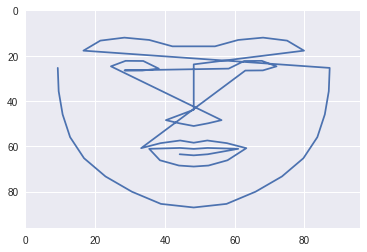

Post cleanup shape  (5836, 68, 2)
Face vector shape  (5836, 136)
SM-Avg shape  (1, 136)
D Shape  (4556, 136)
E Shape  (136, 136)
SM-C shape  (9112, 136)
SM-Diffs shape  (9112,)
EVs: (136, 136)
Coeffs: (5836, 5836)
S: (136,)
n: 12
mean_face: (68, 2)


In [237]:
# 2b) Train the model
matdata = spio.loadmat('./train/300W_train.mat')
mean_face = matdata['mean_face']
train_labels = matdata['train_labels']

print("Mean-Face Shape ", mean_face.shape)
print("Train-Labels Shape ", train_labels.shape)
plt.axis([0, 96, 96, 0])
plt.plot(mean_face[:, 0], mean_face[:, 1])
plt.show()

SM = new_pca_model(train_labels, noisedeg, imgszx, compat)
SM.n = nEVs
# this is actually the same as SM.avg just in different format
SM.mean_face = mean_face
print("mean_face:", SM.mean_face.shape)

First Fit:
     pcost       dcost       gap    pres   dres
 0:  7.8112e+04 -1.3832e+06  2e+06  2e-01  2e+00
 1: -1.3778e+05 -1.2103e+06  1e+06  8e-02  9e-01
 2: -1.8300e+05 -2.6923e+05  9e+04  5e-03  6e-02
 3: -1.8330e+05 -1.8432e+05  1e+03  6e-05  7e-04
 4: -1.8330e+05 -1.8331e+05  1e+01  6e-07  7e-06
 5: -1.8330e+05 -1.8330e+05  1e-01  6e-09  7e-08
Optimal solution found.

Local Fit dxy(20):
     pcost       dcost       gap    pres   dres
 0:  7.8112e+04 -1.3832e+06  2e+06  2e-01  2e+00
 1: -1.3778e+05 -1.2103e+06  1e+06  8e-02  9e-01
 2: -1.8300e+05 -2.6923e+05  9e+04  5e-03  6e-02
 3: -1.8330e+05 -1.8432e+05  1e+03  6e-05  7e-04
 4: -1.8330e+05 -1.8331e+05  1e+01  6e-07  7e-06
 5: -1.8330e+05 -1.8330e+05  1e-01  6e-09  7e-08
Optimal solution found.

Local Fit dxy(7):
     pcost       dcost       gap    pres   dres
 0:  7.8112e+04 -1.3832e+06  2e+06  2e-01  2e+00
 1: -1.3778e+05 -1.2103e+06  1e+06  8e-02  9e-01
 2: -1.8300e+05 -2.6923e+05  9e+04  5e-03  6e-02
 3: -1.8330e+05 -1.8432

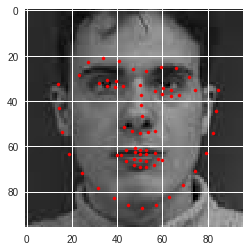

In [239]:
# 3) Fit the model
# x and y are only needed for Kabsch alignment, not for fitting
xmodel, ymodel = fit_compl(SM, pred, x_max, y_max, window_sizes, False,
                           model_constraints, image_boundary_constraints,
                           thresh)
print("\nxmodel\n", np.transpose(xmodel), "\nymodel\n", np.transpose(ymodel))

print("\nMODEL FIT OUTPUT")
print("================")
plot_landmarks(1, lmn, xmodel, ymodel)

In [172]:
#
# Hardcoded output from MATLAB
# Used as a reference for python code
#

"""
xmodel = np.transpose([[17.3795, 16.6992, 16.7025, 18.5280, 22.6728, 28.0020, 33.4724, 38.4403,
   43.8308, 49.3975, 55.2335, 62.1375, 69.6698, 76.5141, 81.2638, 84.3430, 86.6002, 26.7658, 30.5792, 37.3266, 
   44.6403, 50.8223, 55.8628, 62.7747, 70.1134, 75.9867, 78.1626, 52.4565, 51.8302, 51.2211, 50.5645, 43.0143,
   46.1304, 49.6208, 53.2675, 56.7260, 34.8002, 38.4320, 42.2104, 45.4776, 41.9528, 38.1681, 59.1923, 62.9513,
   66.5879, 69.6858, 66.2369, 62.5309, 38.3005, 42.3375, 46.2428, 48.6606, 51.2511, 54.9593, 58.3805, 54.3264,
   50.6452, 47.8037, 45.1015, 41.8577, 40.1275, 46.0221, 48.4918, 51.0513, 56.7660, 50.7656, 48.1345, 45.6131]])

ymodel = np.transpose([[28.6732, 38.5645, 48.5239, 57.9271, 66.4980, 73.6975, 79.6570, 84.1260,
86.3385, 86.5327, 84.6238, 81.0047, 75.9016, 68.8265, 59.8192, 49.5682, 39.3582, 29.3502, 23.5881, 21.3166, 22.6435, 26.4197, 27.0718,
25.0470, 25.7810, 29.7407, 36.2265, 33.1486, 37.7817, 42.3376, 47.2222, 51.4379, 53.1786, 54.4364, 54.1536, 53.3402, 32.3995, 31.2934, 
31.4010, 33.7842, 34.1173, 33.7465, 35.6296, 34.2807, 35.1009, 37.1726, 37.6033, 36.9026, 63.1130, 61.4122, 60.9031, 61.9423, 61.5897,
63.1410, 65.8937, 67.7444, 68.7194, 68.6838, 67.9702, 66.1178, 63.0225, 62.5058, 63.1798, 63.2117, 65.3006, 66.0079,65.9771, 65.2490]])

plot_landmarks("./input_img1.jpg", lmn, xmodel, ymodel)
"""

'\nxmodel = np.transpose([[17.3795, 16.6992, 16.7025, 18.5280, 22.6728, 28.0020, 33.4724, 38.4403,\n   43.8308, 49.3975, 55.2335, 62.1375, 69.6698, 76.5141, 81.2638, 84.3430, 86.6002, 26.7658, 30.5792, 37.3266, \n   44.6403, 50.8223, 55.8628, 62.7747, 70.1134, 75.9867, 78.1626, 52.4565, 51.8302, 51.2211, 50.5645, 43.0143,\n   46.1304, 49.6208, 53.2675, 56.7260, 34.8002, 38.4320, 42.2104, 45.4776, 41.9528, 38.1681, 59.1923, 62.9513,\n   66.5879, 69.6858, 66.2369, 62.5309, 38.3005, 42.3375, 46.2428, 48.6606, 51.2511, 54.9593, 58.3805, 54.3264,\n   50.6452, 47.8037, 45.1015, 41.8577, 40.1275, 46.0221, 48.4918, 51.0513, 56.7660, 50.7656, 48.1345, 45.6131]])\n\nymodel = np.transpose([[28.6732, 38.5645, 48.5239, 57.9271, 66.4980, 73.6975, 79.6570, 84.1260,\n86.3385, 86.5327, 84.6238, 81.0047, 75.9016, 68.8265, 59.8192, 49.5682, 39.3582, 29.3502, 23.5881, 21.3166, 22.6435, 26.4197, 27.0718,\n25.0470, 25.7810, 29.7407, 36.2265, 33.1486, 37.7817, 42.3376, 47.2222, 51.4379, 53.1786, 54.4364, 54.

LOCAL MAXIMA OUTPUT
./input_img1.jpg:


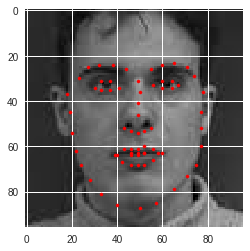

In [240]:
from scipy.sparse import find
import operator

#4) Find nearest local maxima to the model predictions (within each heatmap)

xlocal = np.zeros(xmodel.shape);
ylocal = np.zeros(ymodel.shape);

for i in range(xlocal.shape[0]):
  for j in range(xlocal.shape[1]):
    maxreg = np.transpose(imregionalmax(np.squeeze(pred[:,:,i,j]),ksize=3))
    a = ind2sub(1, maxreg.shape,  find(maxreg==1))
    [a,b] = [a[0][1],a[0][0]] 
    bsxA = (xmodel[i,j]-1-a);
    bsxB = (ymodel[i,j]-1-b);
    min_index, min_value = min(enumerate(np.power(bsxA,2)+np.power(bsxB,2)),
                               key=operator.itemgetter(1))
    xlocal[i,j] = a[min_index];
    ylocal[i,j] = b[min_index];

print("LOCAL MAXIMA OUTPUT")
print("===================")
plot_landmarks(1, lmn, xlocal, ylocal)

FINAL OUTPUT
./input_img1.jpg:


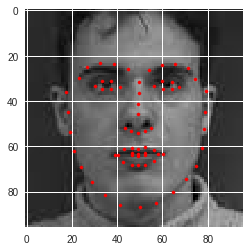

In [241]:
#5) Determine the final coordinates
# Refine the local maxima to sub-pixel accuracy and determine the weighted
# mean between model predictions and local maxima. The more certain the
# network is, the more weight is put on the local maxima. The less certain
# the network is, the more weight is put on the model fitting results.
# Feel free to play around with the weights w.

# radius around the local maxima to consider in order to find sub-pixel maxima
dxy = 2;
xtmp = permute(
    np.reshape(
        minmax(cell2mat(xlocal, dxy), 0, imgszx-1),
        [lmn, 1+2*dxy, imgn])
    ,[0, 2, 1])
ytmp = permute(
    np.reshape(
        minmax(cell2mat(ylocal, dxy), 0, imgszx-1),
        [lmn, 1+2*dxy, imgn])
    ,[0, 2, 1])

xfinal = np.zeros(xlocal.shape);
yfinal = np.zeros(ylocal.shape);

for i in range(0, xlocal.shape[0]):
  for j in range(0, xlocal.shape[1]):
    x = int(xlocal[i,j])
    y = int(ylocal[i,j])
    w = pred[x,y,i,j];
    x_pred = []
    for k in xtmp[i,j,:]:
      x_pred.append(pred[k,ytmp[i,j,:],i,j])
    x_pred = sum1(diff1(np.asarray(x_pred)))
    xfinal[i,j] = (xmodel[i,j] * (1-w)) + w * np.sum(
        np.sum(
            np.transpose(
                np.multiply(
                    np.transpose(x_pred),
                    xtmp[i,j,:])
            )
        )
    )
    yfinal[i,j] = (ymodel[i,j] * (1-w)) + w * np.sum(
        np.sum(
            np.multiply(
                x_pred,ytmp[i,j,:]
            )
        )
    )

print("FINAL OUTPUT")
print("============")
plot_landmarks(1, lmn, xfinal, yfinal)